# (GEO)TIFF CONVERTER
---

In [3]:
import os
import numpy as np
from PIL import Image
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS

# Constants for scaling height tiles
MIN_HEIGHT = 0.0
MAX_HEIGHT = 8191.875

WKT_DEST = """
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["easting (X)",east,
            ORDER[1],
            LENGTHUNIT["metre",1]],
        AXIS["northing (Y)",north,
            ORDER[2],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["Web mapping and visualisation."],
        AREA["World between 85.06°S and 85.06°N."],
        BBOX[-85.06,-180,85.06,180]],
    ID["EPSG",3857]]
"""

def decode_png_to_tiff(png_filename, is_height_tile=False, height_encoding="little"):
    # Derive names
    tiff_path = png_filename.replace(".png", ".tif")
    bounds_file = png_filename.replace(".png", "_aabb.txt")
    
    # Open the PNG image
    img = Image.open(png_filename)
    img = img.convert("RGBA")  # Ensure it has 4 channels
    
    # Load image data into a NumPy array
    data = np.array(img)
    
    if is_height_tile:
        # Extract the first two channels (red and green)
        red = data[:, :, 0].astype(np.uint16)
        green = data[:, :, 1].astype(np.uint16)
        
        # Combine red and green channels based on endian
        if height_encoding == "big":
            uint16_data = (red << 8) | green
        elif height_encoding == "little":
            uint16_data = (green << 8) | red
        else:
            raise ValueError("Invalid endian type. Use 'big' or 'little'.")
        
        # Scale uint16 to float32 using MIN_HEIGHT and MAX_HEIGHT
        scaled_data = MIN_HEIGHT + ((uint16_data / 65535.0) * (MAX_HEIGHT - MIN_HEIGHT))
    else:
        # Use the original RGBA data directly for normal tiles
        scaled_data = data

    if os.path.exists(bounds_file):
        # Read bounds from the text file
        with open(bounds_file, "r") as f:
            bounds = [float(line.strip()) for line in f.readlines()]
        
        if len(bounds) != 4:
            raise ValueError("Bounds file must contain exactly 4 lines: min_x, min_y, max_x, max_y")
        
        # Set bounds (min_x, min_y, max_x, max_y)
        min_x, min_y, max_x, max_y = bounds

        # Calculate transform
        pixel_width = (max_x - min_x) / data.shape[1]
        pixel_height = (max_y - min_y) / data.shape[0]
        transform = from_origin(min_x, max_y, pixel_width, pixel_height)

        # Write GeoTIFF
        with rasterio.open(
            tiff_path, 'w', driver='GTiff',
            height=scaled_data.shape[0], width=scaled_data.shape[1],
            count=1 if is_height_tile else 4,  # 1 band for height tile, 4 for RGBA
            dtype='float32' if is_height_tile else 'uint8',
            crs=CRS.from_wkt(WKT_DEST),
            transform=transform
        ) as dst:
            if is_height_tile:
                dst.write(scaled_data, 1)  # Write to the first band
            else:
                for i in range(4):  # Write RGBA channels
                    dst.write(scaled_data[:, :, i], i + 1)
        print(f"GeoTIFF created: {tiff_path}")
    else:
        # Save as a standard TIFF
        if is_height_tile:
            Image.fromarray(scaled_data.astype(np.float32), mode="F").save(tiff_path, format="TIFF")
        else:
            Image.fromarray(scaled_data.astype(np.uint8), mode="RGBA").save(tiff_path, format="TIFF")
        print(f"TIFF created: {tiff_path}")

def create_height_raster(png_filename, height_encoding="little", tiff_path=None):
    # Derive names
    if tiff_path is None:
        tiff_path = png_filename.replace(".png", ".tif")
    bounds_file = png_filename.replace(".png", "_aabb.txt")
    
    # Open the PNG image
    img = Image.open(png_filename)
    img = img.convert("RGBA")  # Ensure it has 4 channels
    
    # Load image data into a NumPy array
    data = np.array(img)
    
    # Extract the first two channels (red and green)
    red = data[:, :, 0].astype(np.uint16)
    green = data[:, :, 1].astype(np.uint16)
        
    # Combine red and green channels based on endian
    if height_encoding == "big":
        uint16_data = (red << 8) | green
    elif height_encoding == "little":
        uint16_data = (green << 8) | red
    else:
        raise ValueError("Invalid endian type. Use 'big' or 'little'.")
        
    # Scale uint16 to float32 using MIN_HEIGHT and MAX_HEIGHT
    scaled_data = MIN_HEIGHT + ((uint16_data / 65535.0) * (MAX_HEIGHT - MIN_HEIGHT))

    if os.path.exists(bounds_file):
        # Read bounds from the text file
        with open(bounds_file, "r") as f:
            bounds = [float(line.strip()) for line in f.readlines()]
        
        if len(bounds) != 4:
            raise ValueError("Bounds file must contain exactly 4 lines: min_x, min_y, max_x, max_y")
        
        # Set bounds (min_x, min_y, max_x, max_y)
        min_x, min_y, max_x, max_y = bounds

        # Calculate transform
        pixel_width = (max_x - min_x) / data.shape[1]
        pixel_height = (max_y - min_y) / data.shape[0]
        transform = from_origin(min_x, max_y, pixel_width, pixel_height)

        # Write GeoTIFF
        with rasterio.open(
            tiff_path, 'w', driver='GTiff',
            height=scaled_data.shape[0], width=scaled_data.shape[1],
            count=1,
            dtype='float32',
            crs=CRS.from_wkt(WKT_DEST),
            transform=transform,
            nodata=0  # Set NoData value to 0
        ) as dst:
            dst.write(scaled_data, 1)  # Write to the first band
        print(f"GeoTIFF created: {tiff_path}")
    else:
        # Save as a standard TIFF
        Image.fromarray(scaled_data.astype(np.float32), mode="F").save(tiff_path, format="TIFF")
        print(f"TIFF created: {tiff_path}")


def create_rp_raster(png_filename, tiff_path=None):
    # Derive names
    if tiff_path is None:
        tiff_path = png_filename.replace(".png", ".tif")
    bounds_file = png_filename.replace(".png", "_aabb.txt")
    
    # Open the PNG image
    img = Image.open(png_filename)
    img = img.convert("RGBA")  # Ensure it has 4 channels
    
    # Load image data into a NumPy array
    data = np.array(img)
    
    # Extract height data (red channel)
    scaled_data = data[:, :, 0].astype(np.float32)

    if os.path.exists(bounds_file):
        # Read bounds from the text file
        with open(bounds_file, "r") as f:
            bounds = [float(line.strip()) for line in f.readlines()]
        
        if len(bounds) != 4:
            raise ValueError("Bounds file must contain exactly 4 lines: min_x, min_y, max_x, max_y")
        
        # Set bounds (min_x, min_y, max_x, max_y)
        min_x, min_y, max_x, max_y = bounds

        # Calculate transform
        pixel_width = (max_x - min_x) / data.shape[1]
        pixel_height = (max_y - min_y) / data.shape[0]
        transform = from_origin(min_x, max_y, pixel_width, pixel_height)

        # Write GeoTIFF with NoData value set to 0
        with rasterio.open(
            tiff_path, 'w', driver='GTiff',
            height=scaled_data.shape[0], width=scaled_data.shape[1],
            count=1,  # Single band for height data
            dtype='float32',
            crs=CRS.from_wkt(WKT_DEST),
            transform=transform,
            nodata=0  # Set NoData value to 0
        ) as dst:
            dst.write(scaled_data, 1)  # Write to the first band
        print(f"GeoTIFF created: {tiff_path}")
    else:
        # Save as a standard TIFF without geospatial information
        Image.fromarray(scaled_data.astype(np.float32), mode="F").save(tiff_path, format="TIFF")
        print(f"TIFF created: {tiff_path}")



In [3]:
APP_DIR = r"C:\tmp\webigeo\build-webigeo-Desktop_Qt_6_7_2_MSVC2022_64bit_Custom-Release\webgpu_app"
AVA_DIR = r"C:\tmp\webigeo\AvaFrame\avaframe\data\avaWeBIGeo2"

# call create_height_raster for height_export/18.png and save the result to AVA_DIR/Inputs/DEM.tif
create_height_raster(os.path.join(APP_DIR, "height_export/18.png"), height_encoding="little", tiff_path=os.path.join(AVA_DIR, "Inputs/DEM.tif"))

# call create_rp_raster for rp_export/18.png and save the result to AVA_DIR/Inputs/REL/RP.tif
create_rp_raster(os.path.join(APP_DIR, "rp_export/18.png"), tiff_path=os.path.join(AVA_DIR, "Inputs/REL/RP.tif"))


GeoTIFF created: C:\tmp\webigeo\AvaFrame\avaframe\data\avaWeBIGeo2\Inputs/DEM.tif
GeoTIFF created: C:\tmp\webigeo\AvaFrame\avaframe\data\avaWeBIGeo2\Inputs/REL/RP.tif


---
# Processing of AvaFrame Results


In [6]:
import matplotlib.pyplot as plt

# Define constants for bounds
FLOAT_MIN_ENCODING = -10000.0
FLOAT_MAX_ENCODING = 10000.0

def create_overlay_png(tiff_filename, output_png_filename=None):
    # Derive the output filename if not specified
    if output_png_filename is None:
        output_png_filename = os.path.splitext(tiff_filename)[0] + ".png"
    
    # Open the GeoTIFF file
    with rasterio.open(tiff_filename) as src:
        # Read the first band
        band1 = src.read(1)  # Read the first band as a NumPy array

    # Clamp values to the range FLOAT_MIN_ENCODING to FLOAT_MAX_ENCODING
    band1_clamped = np.clip(band1, FLOAT_MIN_ENCODING, FLOAT_MAX_ENCODING)
    
    # Normalize the clamped values to the range 0-1
    band1_normalized = (band1_clamped - FLOAT_MIN_ENCODING) / (FLOAT_MAX_ENCODING - FLOAT_MIN_ENCODING)  # Scale [FLOAT_MIN_ENCODING, FLOAT_MAX_ENCODING] to [0, 1]
    
    # Scale normalized values to fit within a 32-bit unsigned integer range
    band1_scaled = (band1_normalized * 4294967295).astype(np.uint32)  # [0, 1] -> [0, 2^32-1]

    # Split 32-bit values into RGBA channels
    rgba_data = np.zeros((band1.shape[0], band1.shape[1], 4), dtype=np.uint8)
    rgba_data[:, :, 0] = (band1_scaled >> 24) & 0xFF  # Extract highest 8 bits
    rgba_data[:, :, 1] = (band1_scaled >> 16) & 0xFF  # Extract next 8 bits
    rgba_data[:, :, 2] = (band1_scaled >> 8) & 0xFF   # Extract next 8 bits
    rgba_data[:, :, 3] = band1_scaled & 0xFF          # Extract lowest 8 bits

    # Create a PIL Image from the RGBA array
    img = Image.fromarray(rgba_data, mode="RGBA")

    # Show img
    plt.imshow(img)

    # Save the image as a PNG
    img.save(output_png_filename, format="PNG")
    print(f"Overlay PNG created: {output_png_filename}")

def decode_uint32_float_png(png_filename, output_tiff_filename, big_endian=True):
    # Open the PNG file
    img = Image.open(png_filename)
    rgba_data = np.array(img)

    # Combine RGBA channels into a single uint32 value
    if big_endian:
        band1_scaled = (
            (rgba_data[:, :, 0].astype(np.uint32) << 24) |
            (rgba_data[:, :, 1].astype(np.uint32) << 16) |
            (rgba_data[:, :, 2].astype(np.uint32) << 8) |
            rgba_data[:, :, 3].astype(np.uint32)
        )
    else:
        band1_scaled = (
            (rgba_data[:, :, 3].astype(np.uint32) << 24) |
            (rgba_data[:, :, 2].astype(np.uint32) << 16) |
            (rgba_data[:, :, 1].astype(np.uint32) << 8) |
            rgba_data[:, :, 0].astype(np.uint32)
        )

    # Undo normalization to get float values
    band1_normalized = band1_scaled / 4294967295.0  # Scale [0, UINT32_MAX] back to [0, 1]
    band1_decoded = (band1_normalized * (FLOAT_MAX_ENCODING - FLOAT_MIN_ENCODING)) + FLOAT_MIN_ENCODING

    # Convert the float array back to an image and save as TIFF
    band1_image = Image.fromarray(band1_decoded.astype(np.float32), mode="F")
    band1_image.save(output_tiff_filename, format="TIFF")
    print(f"Decoded TIFF created: {output_tiff_filename}")

Overlay PNG created: C:\tmp\webigeo\build-webigeo-Desktop_Qt_6_7_2_MSVC2022_64bit_Custom-Release\webgpu_app\avaframe_simulations\breiteries_a25_e300_f0.0003_mz8848_cellCounts.png
Processed: C:\tmp\webigeo\AvaFrame\avaframe\data\avaWeBIGeo2\Outputs\com4FlowPy\peakFiles\res_e4d50ae404\com4_e4d50ae404_20241203_151459_cellCounts.tif -> C:\tmp\webigeo\build-webigeo-Desktop_Qt_6_7_2_MSVC2022_64bit_Custom-Release\webgpu_app\avaframe_simulations\breiteries_a25_e300_f0.0003_mz8848_cellCounts.png
Overlay PNG created: C:\tmp\webigeo\build-webigeo-Desktop_Qt_6_7_2_MSVC2022_64bit_Custom-Release\webgpu_app\avaframe_simulations\breiteries_a25_e300_f0.0003_mz8848_fpTravelAngle.png
Processed: C:\tmp\webigeo\AvaFrame\avaframe\data\avaWeBIGeo2\Outputs\com4FlowPy\peakFiles\res_e4d50ae404\com4_e4d50ae404_20241203_151459_fpTravelAngle.tif -> C:\tmp\webigeo\build-webigeo-Desktop_Qt_6_7_2_MSVC2022_64bit_Custom-Release\webgpu_app\avaframe_simulations\breiteries_a25_e300_f0.0003_mz8848_fpTravelAngle.png
Overlay

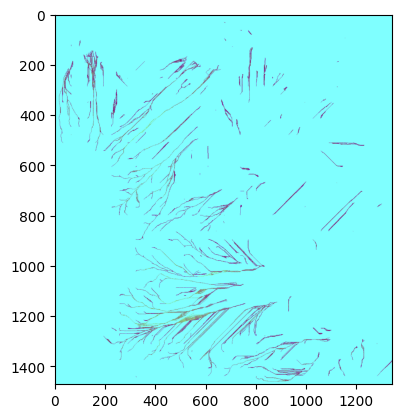

In [7]:
import os
import glob

# Constants
TIFF_DIR = r"C:\tmp\webigeo\AvaFrame\avaframe\data\avaWeBIGeo2\Outputs\com4FlowPy\peakFiles\res_e4d50ae404"
TRACKNAME = r"breiteries_a25_e300_f0.0003_mz8848"  # Default track name

# Function to extract the type from the filename
def extract_type(filename):
    # Extract everything between the last underscore and the ".tif" extension
    base_name = os.path.basename(filename)
    type_part = base_name.split('_')[-1]  # Get the last part before ".tif"
    return type_part.split('.')[0]


def process_tiff_files(folder_path):
    # Find all TIFF files in the folder
    tiff_files = glob.glob(os.path.join(folder_path, "*.tif"))

    # Ensure output directory exists
    output_dir = os.path.join(APP_DIR, "avaframe_simulations")
    os.makedirs(output_dir, exist_ok=True)

    for tiff_file in tiff_files:
        # Extract the type from the filename
        tiff_type = extract_type(tiff_file)

        # Construct the output filename
        output_filename = os.path.join(output_dir, f"{TRACKNAME}_{tiff_type}.png")

        # Call the create_overlay_png function
        create_overlay_png(tiff_file, output_png_filename=output_filename)
        print(f"Processed: {tiff_file} -> {output_filename}")

process_tiff_files(TIFF_DIR)


In [9]:
decode_uint32_float_png(r"C:\tmp\asd2.png", r"C:\tmp\asd2.tif", big_endian=False)

Decoded TIFF created: C:\tmp\asd2.tif
